# Modèles de base

This notebook is to do the preliminary models for our pipeline

In [1]:
import pandas as pd

from ift6758.pipeline import ExperimentPipeline, DEFAULT_TRANSFORMATIONS

In [2]:
%%time
df = ExperimentPipeline.get_data('../data/tabular', transformations=DEFAULT_TRANSFORMATIONS)
df.head()

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing
CPU times: user 6.74 s, sys: 2.84 s, total: 9.58 s
Wall time: 10.2 s


,game_starttime,game_endtime,game_id,datetime,offense_team_id,offense_team_name,offense_team_tricode,goal,x_coords,y_coords,...,strength_powerplay,season,shot_angle,shot_distance,game_secs,time_lapsed_prev_event_in_seconds,dist_prev_event,rebound,angle_change,speed
0,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:19:59Z,10,Toronto Maple Leafs,TOR,0,77.0,-5.0,...,0.0,20162017,67.380135,13.000000,71,0,138.924440,False,0.0,-1.000000
1,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:21:41Z,9,Ottawa Senators,OTT,0,86.0,13.0,...,0.0,20162017,12.994617,13.341664,173,0,36.715120,False,0.0,-1.000000
2,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:23:17Z,9,Ottawa Senators,OTT,0,23.0,-38.0,...,0.0,20162017,60.068488,76.157731,241,18,102.318131,False,0.0,5.684341
3,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:24:02Z,9,Ottawa Senators,OTT,0,33.0,-15.0,...,0.0,20162017,75.004921,57.974132,286,19,45.880279,False,0.0,2.414752
4,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:27:30Z,10,Toronto Maple Leafs,TOR,0,34.0,-28.0,...,0.0,20162017,63.019769,61.717096,406,15,63.348244,False,0.0,4.223216


## Experiments

In [3]:
# # FOR COMET LOGGING
# import os
# from getpass import getpass
#
# os.environ['COMET_API_KEY'] = getpass()

### Simple Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

pipeline = ExperimentPipeline(
    tabular_dir='../data/tabular',
    feature_columns=['shot_distance'],
    target_column='goal',
    pipeline_steps=[
        ('logreg', LogisticRegression()),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[
        {'logreg__penalty': ['l2'], 'logreg__C': [1]},
    ],
    metric='accuracy',
    enable_comet=False
)

In [5]:
pipeline.run()

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.6s
[CV 2/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.5s
[CV 3/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.6s
[CV 4/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.8s
[CV 5/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.7s


In [6]:
metrics = pipeline.get_metrics('valid')
f"Best accuracy: {metrics['accuracy']}"

'Best accuracy: 0.9023798801399522'

In [7]:
x_train, y_train = pipeline.dataset['x_train'], pipeline.dataset['y_train']
x_valid, y_valid = pipeline.dataset['x_valid'], pipeline.dataset['y_valid']
best_model = pipeline.grid.best_estimator_

preds = best_model.predict(x_valid)

In [8]:
pd.Series(preds).value_counts()

0    57734
dtype: int64

Our model always predicts the majority class, meaning the failed shot. We need to adjust our metric to consider this imbalance

In [9]:
import numpy as np

class UniformClassifier:
    def predict(self, x):
        return (self.predict_proba(x) > 0.5).astype(int)

    def predict_proba(self, x):
        np.random.seed(42)
        m, n = x.shape
        p = np.random.rand(m)
        return np.array([p, 1-p]).T

baseline = UniformClassifier()

In [10]:
model_results = [
    (y_valid, best_model.predict_proba(x_valid)[:,1], 'best_model'),
    (y_valid, baseline.predict_proba(x_valid)[:,1], 'baseline')
]

truth  = [_[0] for _ in model_results]
probas = [_[1] for _ in model_results]
labels = [_[2] for _ in model_results]

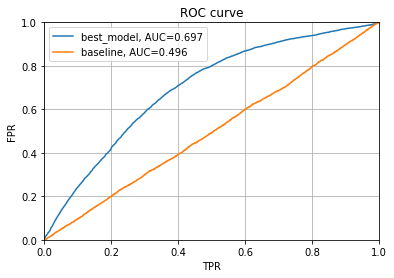

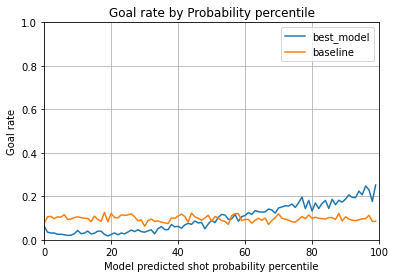

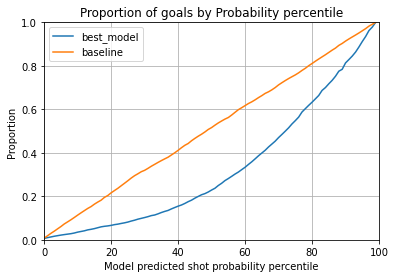

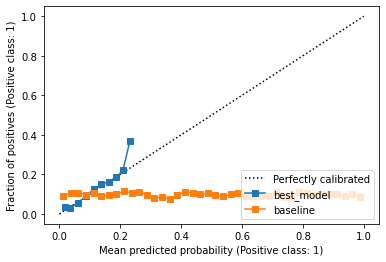

In [11]:
from ift6758.pipeline.plots import *
plot_all(truth, probas, labels)

### Feature Performance Comparison

In [12]:
DEFAULT_PARAMETERS = {
    'tabular_dir': '../data/tabular',
    'feature_columns': ['shot_distance'],
    'target_column': 'goal',
    'pipeline_steps': [
        ('logreg', LogisticRegression()),
    ],
    'dataset_transformations': DEFAULT_TRANSFORMATIONS,
    'parameter_grid': [
        {'logreg__penalty': ['l2'], 'logreg__C': [1]},
    ],
    'metric': 'accuracy',
    'enable_comet': False
}

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.6s
[CV 2/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.6s
[CV 3/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.6s
[CV 4/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.6s
[CV 5/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.906 total time=   0.8s
fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_

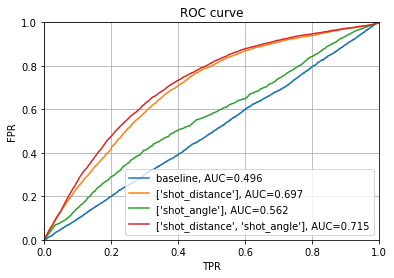

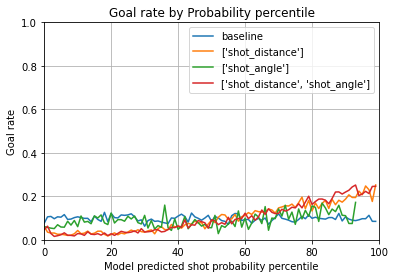

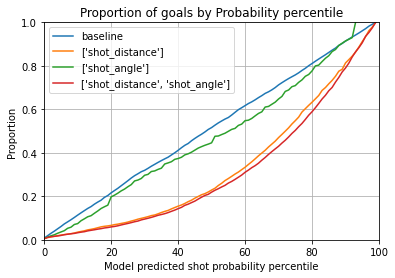

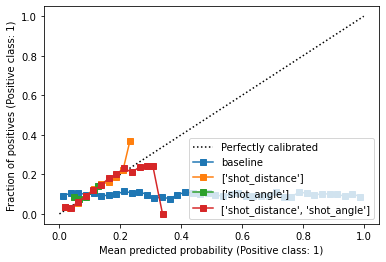

In [13]:
truth, probas, labels = [y_valid], [baseline.predict_proba(x_valid)[:,1]], ['baseline']
for features in [
    ['shot_distance'],
    ['shot_angle'],
    ['shot_distance', 'shot_angle']
]:
    params = DEFAULT_PARAMETERS.copy()
    params['feature_columns'] = features

    pipeline = ExperimentPipeline(**params)
    pipeline.run()

    truth.append(pipeline.dataset['y_valid'])
    probas.append(pipeline.get_probas('valid'))
    labels.append(str(features))

plot_all(truth, probas, labels)